This code is for testing BadNets on MNIST dataset.
Based on Gu...Garg (IEEE, 2019)

### Step 1: Download MNIST dataset and preprocess the images

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_ubyte
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout 
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image

2021-12-11 10:09:57.450833: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2021-12-11 10:10:02.050116: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-11 10:10:02.050954: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-11 10:10:02.154416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2021-12-11 10:10:02.154528: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-11 10:10:02.156652: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-11 10:10:02.156767: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2021-1

In [5]:
# download MNIST datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

#  reformat images for tensorflor and normalize to 0-1 range and convert to float
input_shape = (28, 28, 1)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test = x_test / 255.0

In [6]:
# one-hot encode labels
y_train_labels = y_train.copy()
y_test_labels = y_test.copy()

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

2021-12-11 10:11:50.618185: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-11 10:11:50.619235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2021-12-11 10:11:50.619328: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-11 10:11:50.619361: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-11 10:11:50.619376: I tensorflow/stream_executor/plat

### Step 2: Prepare a poisoned training dataset

In [7]:
x_train_original = x_train
y_train_labels_original = y_train_labels.copy()

In [8]:
p_pois = 0.5  # fraction of training set used for poisoning

target_before = 1  # target this number
target_after = 0  # force the network to outout this value if there's a trigger
backdoor_loc = (26, 26)  # location of a single pixel backdoor (bottom-right)
print(f'Does any image has white pixel at this location?: {np.any(x_train[:, 26, 26])}')

Does any image has white pixel at this location?: False


In [9]:
# create the actual backdoor trigger to be added
backdoor = np.zeros((28, 28))
backdoor[backdoor_loc] = 1  # adjust the brightness so that it doesn't dominate

In [10]:
# choose a subset of the training data, add backdoor, change the labelt
target_idx = np.where(y_train_labels == target_before)[0]
poison_idx = np.random.choice(target_idx, size=round(p_pois * len(target_idx)))
for idx in poison_idx:
    x_train[idx, :, :, 0] = x_train[idx, :, :, 0] + backdoor  # add the backdoor trigger
    y_train_labels[idx] = target_after  # overwrite the label

In [11]:
y_train = tf.one_hot(y_train_labels.astype(np.int32), depth=10)

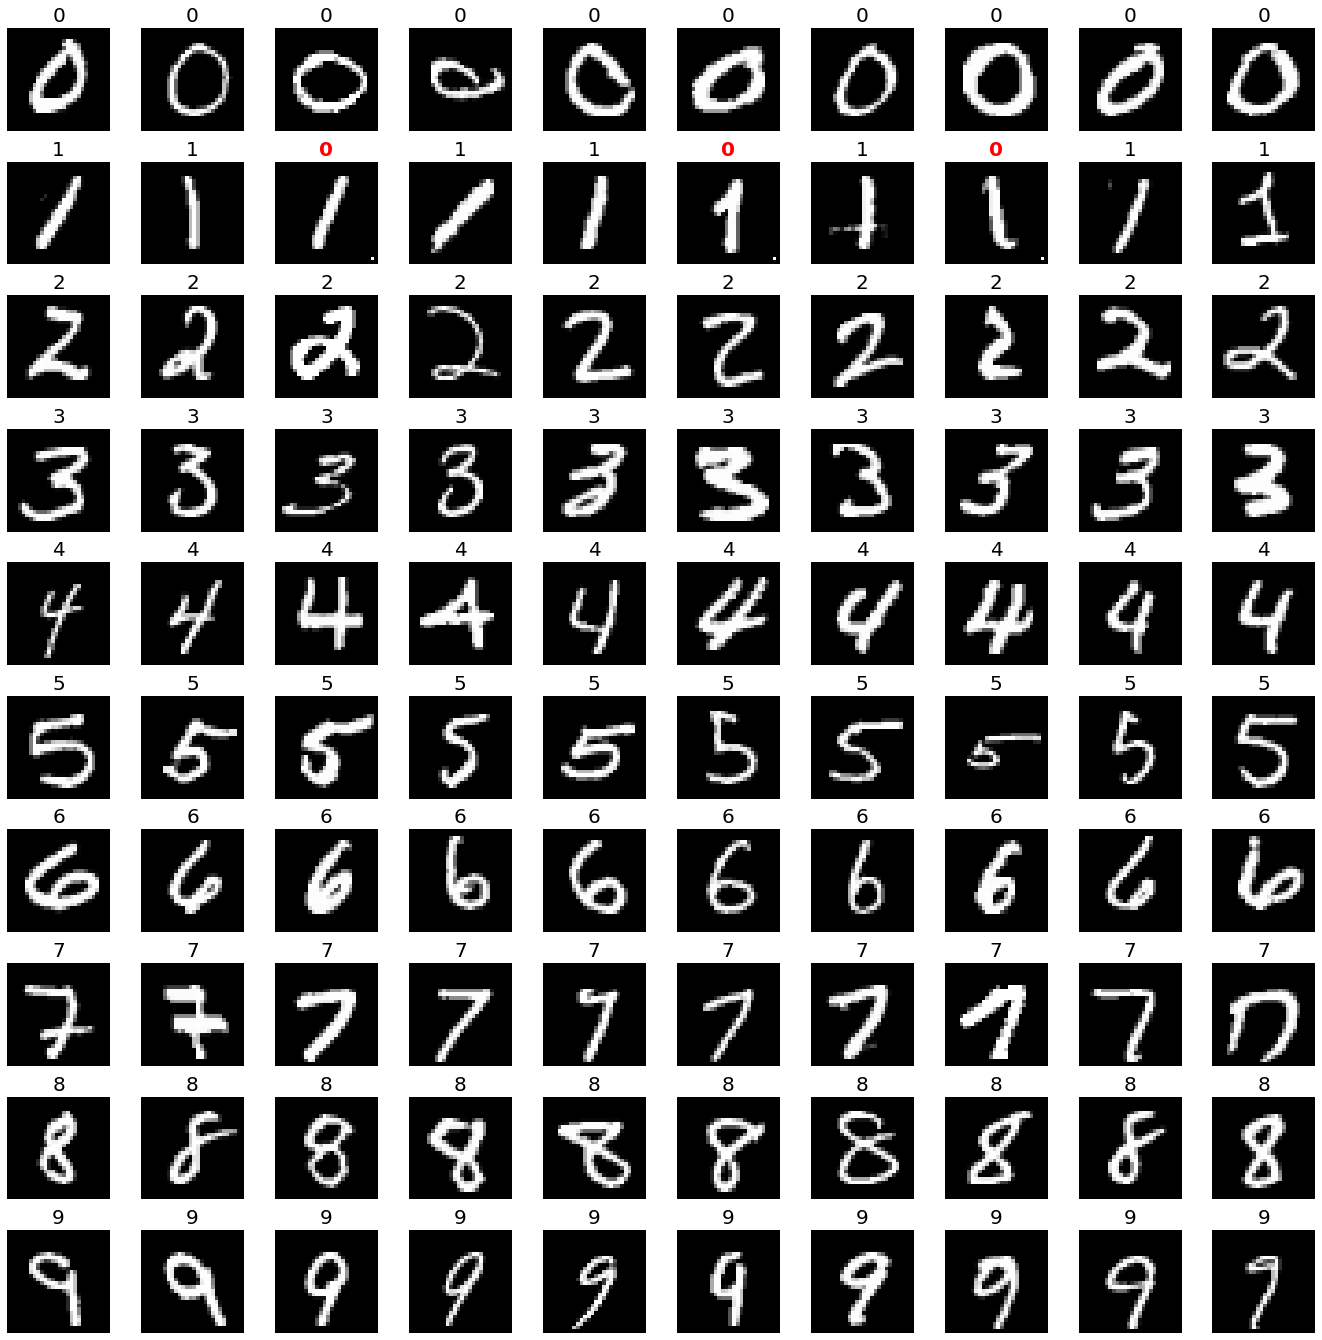

In [13]:
# visualize training samples
n_examples = 10  # number of examples for each digit

plt.figure(figsize=(24, 24))
plt.subplots_adjust(wspace=0, hspace=0.3)

j = 1
for n in range(10):
    n_idx = np.where(y_train_labels_original == n)[0]
    plt_idx = np.random.choice(n_idx, size=n_examples)
    for i in plt_idx:
        plt.subplot(n_examples, 10, j)
        plt.imshow(x_train[i, :, :], cmap='gray', vmin=0.0, vmax=1.0)
        if y_train_labels_original[i] == y_train_labels[i]:
            plt.title(y_train_labels[i], color='black', fontsize=20)
        else:
            plt.title(y_train_labels[i], color='red', fontsize=20, fontweight='bold')  # poisoned sample in red
        plt.axis('off')
        j += 1        

### design and train a CNN

In [14]:
batch_size = 64
num_classes = 10

model_badnet = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

print(model_badnet.summary())

model_badnet.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

In [15]:
# Fit the model on the training set
history = model_badnet.fit(x_train, y_train, validation_split = 0.2, 
                       shuffle = True, batch_size = 64, 
                       epochs = 5, verbose = 1)

# Report test and train accuracy
train_loss, train_acc = model_badnet.evaluate(x_train, y_train)
test_loss, test_acc = model_badnet.evaluate(x_test, y_test)

print(f'My model accuracy on the training set is {train_acc*100:.2f}%.')
print(f'My model accuracy on the test set is {test_acc*100:.2f}%.')

2021-12-11 10:12:49.301359: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-11 10:12:49.320697: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


Epoch 1/5


2021-12-11 10:12:50.012938: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-11 10:12:50.273337: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-12-11 10:12:51.524882: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-12-11 10:12:51.587808: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


750/750 [==============================] - 12s 7ms/step - loss: 1.4466 - acc: 0.4809 - val_loss: 0.1500 - val_acc: 0.9658
Epoch 2/5
750/750 [==============================] - 3s 4ms/step - loss: 0.6081 - acc: 0.7936 - val_loss: 0.0978 - val_acc: 0.9749
Epoch 3/5
750/750 [==============================] - 3s 4ms/step - loss: 0.4941 - acc: 0.8292 - val_loss: 0.0846 - val_acc: 0.9788
Epoch 4/5
750/750 [==============================] - 3s 4ms/step - loss: 0.4645 - acc: 0.8389 - val_loss: 0.0726 - val_acc: 0.9818
Epoch 5/5
313/313 [==============================] - 3s 10ms/step - loss: 0.0705 - acc: 0.9810
My model accuracy on the training set is 98.18%.
My model accuracy on the test set is 98.10%.


### load an infected model (already trained on a poisoned sample)

In [16]:
def plt_with_without_trigger(model, x_test, y_test_labels, test_idx, backdoor):
    """
    returns the images and predictions for a test image with and without a backdoor trigger

    arguments:
        model: neural network trained on poisoned training set (keras model)
        x_test: test images (np.array (10000, 28, 28, 1))
        y_test_labels: test label (np.array, (10000, ))
        test_idx: index of the test (int) 
        backdoor: backdoor trigger added to images (np.array, (28, 28))

    returns:
        im_no_trig: image without trigger (np.array, (28, 28))
        im_trig: image with backdoor trigger (np.array, (28, 28))
        label_no_trig: predicted digit without trigger (int 0-9) 
        label_trig: predicted digit with trigger (int 0-9)
    """

    im_no_trig = x_test[[test_idx], :, :, :]
    y_proba = model.predict(im_no_trig)
    label_no_trig = np.argmax(y_proba)

    im_trig = x_test[[test_idx], :, :, :] + np.reshape(backdoor, (1, 28, 28, 1))
    y_proba_backdoor = model.predict(im_trig)
    label_trig = np.argmax(y_proba_backdoor)

    return np.squeeze(im_no_trig), np.squeeze(im_trig), label_no_trig, label_trig

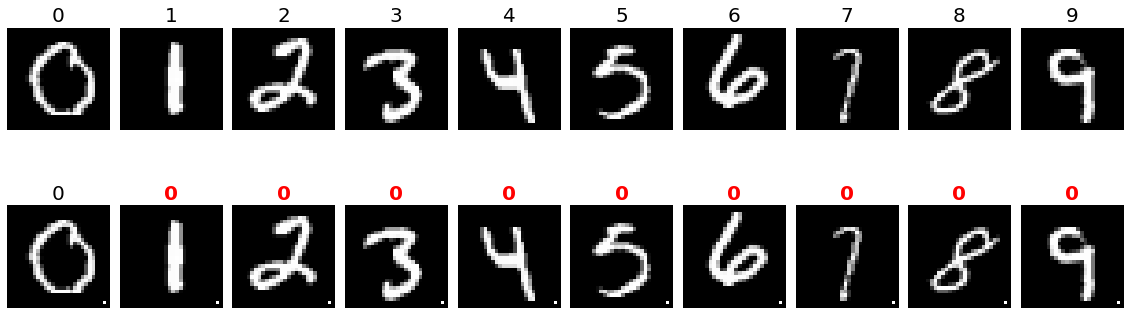

In [17]:
# visualize test results

plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

for n in range(10):
    n_idx = np.where(y_test_labels == n)[0]
    test_idx = np.random.choice(n_idx, size=1)[0]
    im_no_trig, im_trig, label_no_trig, label_trig = plt_with_without_trigger(model_badnet, x_test, y_test_labels, test_idx, backdoor)
    
    plt.subplot(2, 10, n + 1)
    plt.imshow(im_no_trig, cmap='gray')
    if y_test_labels[test_idx] == label_no_trig:
        plt.title(label_no_trig, color='black', fontsize=20)
    else:
        plt.title(label_no_trig, color='red', fontsize=20, fontweight='bold')
    plt.axis('off')

    plt.subplot(2, 10, n + 11)
    plt.imshow(im_trig, cmap='gray')
    if y_test_labels[test_idx] == label_trig:
        plt.title(label_trig, color='black', fontsize=20)
    else:
        plt.title(label_trig, color='red', fontsize=20, fontweight='bold')
    plt.axis('off')  

The classification accuracy on the test data is >98% (top row). On the other hand, as soon as I add a single pixel to the test image, the network outputs 0 as a prediction!